In [1]:
import numpy as np
import pandas as pd
import helper_functions as hf
import keras_tuner as kt
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [2]:
nickel_data = pd.read_csv("final_test.csv", index_col=0)
nickel_data = nickel_data.drop(columns=["Name", "URL", "Unnamed: 46", "Density"])
nickel_data.head()

,"Tensile Strength, Ultimate","Tensile Strength, Yield",Elongation at Break,Al,B,C,Cr,Fe,Mn,Ni,...,Pb,O,Re,Se,Ag,Zn,Nd,Pd,Ru,Th
0,1440.0,1265.0,5.3,4.5,0.01,0.05,16.0,3.0,0.5,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,490.0,248.0,23.0,0.0,0.00,0.01,22.0,3.0,0.5,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,970.0,565.0,42.0,0.4,0.00,0.10,21.0,5.0,0.5,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,620.0,410.0,42.0,0.0,0.00,0.05,25.0,0.0,0.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,895.0,490.0,43.8,0.4,0.00,0.10,21.0,5.0,0.5,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train a neural network for UTS

In [3]:
uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
uts_data = uts_data.drop(
    columns=['Tensile Strength, Yield', 'Elongation at Break'])
uts_data = uts_data.fillna(0)
uts_data = uts_data.astype("float32")

uts_train_data = uts_data.sample(frac=0.8, random_state=2212)
uts_test_data = uts_data.drop(uts_train_data.index)

uts_data.head()

,"Tensile Strength, Ultimate",Al,B,C,Cr,Fe,Mn,Ni,Si,Y,...,Pb,O,Re,Se,Ag,Zn,Nd,Pd,Ru,Th
0,1440.0,4.5,0.01,0.05,16.0,3.0,0.5,75.0,0.20,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,490.0,0.0,0.00,0.01,22.0,3.0,0.5,56.0,0.08,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,970.0,0.4,0.00,0.10,21.0,5.0,0.5,62.0,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,620.0,0.0,0.00,0.05,25.0,0.0,0.0,65.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,895.0,0.4,0.00,0.10,21.0,5.0,0.5,62.0,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
uts_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
"Tensile Strength, Ultimate",1338.0,9.772839e+02,346.191498,45.0,758.625000,965.000000,1235.000000,2068.000000
Al,1338.0,1.605628e+00,1.989978,0.0,0.060000,0.500000,2.630000,25.004999
B,1338.0,1.650060e-02,0.212270,0.0,0.000000,0.004000,0.013000,7.500000
C,1338.0,7.542638e-02,0.370207,0.0,0.020000,0.050000,0.090000,13.001000
Cr,1338.0,1.556370e+01,7.128424,0.0,13.200000,16.260000,20.000000,49.500000
Fe,1338.0,6.665499e+00,10.465779,0.0,0.000000,2.000000,7.000000,50.000000
Mn,1338.0,3.320437e-01,0.638214,0.0,0.000000,0.100000,0.500000,14.250500
Ni,1338.0,5.947419e+01,13.480539,20.0,53.349998,57.470001,63.331249,100.000000
Si,1338.0,2.836491e-01,0.711374,0.0,0.000000,0.080000,0.400000,19.000500
Y,1338.0,6.464873e-04,0.016592,0.0,0.000000,0.000000,0.000000,0.605000


In [5]:
uts_train_features = uts_train_data.copy()
uts_test_features = uts_test_data.copy()

uts_train_labels = uts_train_features.pop("Tensile Strength, Ultimate")
uts_test_labels = uts_test_features.pop("Tensile Strength, Ultimate")

In [6]:
uts_normalizer = hf.normalize(uts_train_features)

First example: [[ 0.    0.    0.1  20.    3.    3.   67.    0.    0.    0.    0.12  0.5
   0.    0.    2.5   0.75  0.    0.5   0.    0.03  0.01  0.3   0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]]

Normalized: [[-0.81 -0.08  0.07  0.62 -0.35  4.18  0.56 -0.4  -0.04 -0.08 -0.76 -0.8
  -0.44 -0.22  0.77 -0.25 -0.03 -0.01 -0.03 -0.1   1.02 -0.07 -0.12 -0.1
  -0.07 -0.04 -0.03 -0.05 -0.06 -0.04 -0.07 -0.03 -0.03 -0.03 -0.04  0.
   0.    0.    0.  ]]


In [7]:
hf.model_builder(kt.HyperParameters(), uts_normalizer)

In [8]:
tuner = kt.Hyperband(lambda hp : hf.model_builder(hp, norm=uts_normalizer),
                     objective='val_loss',
                     max_epochs=5,
                     factor=3,
                     directory='model_search',
                     project_name='uts_model',
                     hyperband_iterations=2,
                     overwrite=True)

es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [9]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 1
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 200, 'step': 1, 'sampling': None}


In [10]:
tuner.search(uts_train_features, uts_train_labels, epochs=5, validation_split=0.2, callbacks=[es], verbose=2)


Trial 1 Complete [00h 00m 01s]
val_loss: 628.464599609375

Best val_loss So Far: 628.464599609375
Total elapsed time: 00h 00m 01s
INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary()

Results summary
Results in model_search\uts_model
Showing 10 best trials
Trial summary
Hyperparameters:
layer_1_units: 200
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 628.464599609375


In [12]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [13]:
best_hps.get_config()['values']

{'layer_1_units': 200,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [14]:
uts_model = tuner.hypermodel.build(best_hps)

uts_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 39)               79        
 n)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 39)                0         
                                                                 
 dense_2 (Dense)             (None, 200)               8000      
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 8,280
Trainable params: 8,201
Non-trainable params: 79
___________________________________________________

In [15]:
history = uts_model.fit(uts_train_features, uts_train_labels, epochs=10000, callbacks=[es], validation_split=0.2, verbose=2)

Epoch 1/10000
34/34 - 0s - loss: 961.8605 - val_loss: 896.1758 - 490ms/epoch - 14ms/step
Epoch 2/10000
34/34 - 0s - loss: 796.4094 - val_loss: 614.5269 - 56ms/epoch - 2ms/step
Epoch 3/10000
34/34 - 0s - loss: 443.4575 - val_loss: 286.0993 - 57ms/epoch - 2ms/step
Epoch 4/10000
34/34 - 0s - loss: 281.1675 - val_loss: 252.9599 - 52ms/epoch - 2ms/step
Epoch 5/10000
34/34 - 0s - loss: 261.9459 - val_loss: 244.1083 - 48ms/epoch - 1ms/step
Epoch 6/10000
34/34 - 0s - loss: 254.2947 - val_loss: 234.5378 - 51ms/epoch - 2ms/step
Epoch 7/10000
34/34 - 0s - loss: 249.6005 - val_loss: 228.6242 - 52ms/epoch - 2ms/step
Epoch 8/10000
34/34 - 0s - loss: 246.8989 - val_loss: 224.2980 - 51ms/epoch - 2ms/step
Epoch 9/10000
34/34 - 0s - loss: 246.7913 - val_loss: 218.3611 - 53ms/epoch - 2ms/step
Epoch 10/10000
34/34 - 0s - loss: 235.3038 - val_loss: 213.0110 - 47ms/epoch - 1ms/step
Epoch 11/10000
34/34 - 0s - loss: 242.0964 - val_loss: 214.1071 - 48ms/epoch - 1ms/step
Epoch 12/10000
34/34 - 0s - loss: 233.7

In [16]:
uts_model.evaluate(uts_test_features, uts_test_labels, verbose=0)

193.82601928710938

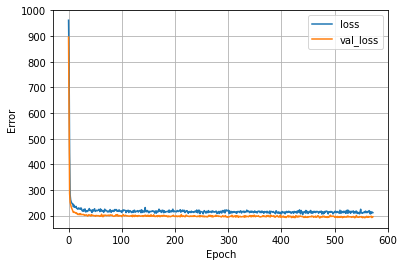

In [17]:
hf.plot_loss(history)

11/11 [==============================] - 0s 601us/step


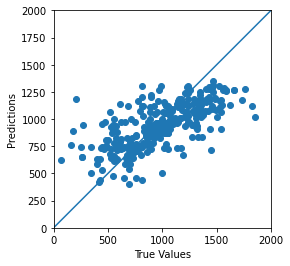

In [18]:
test_predictions = uts_model.predict(uts_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(uts_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)